# Comparing Kallisto quantification to STAR+RSEM

Paper: https://www.nature.com/articles/ncomms15081
    1. Fetch the data from the SRA for scRNASeq/bulkRNASeq/WES
    2. Run Trimmomatic on all libraries 
    3. Run Kallisto on the RNA libraries

Fetch sample table from https://www.ncbi.nlm.nih.gov/Traces/study/?pl=%7B%22page%22%3A1%2C%20%22page_size%22%3A50%2C%20%22sort%22%3A%7B%7D%2C%20%22facet%22%3A%7B%22limit%22%3A100%2C%20%22fields%22%3A%7B%7D%7D%2C%20%22selection%22%3A%5B%5D%2C%20%22sum%22%3A%7B%22count%22%3A%7B%22n%22%3A0%2C%20%22v%22%3A0%7D%7D%7D&acc=PRJNA305054

and dumped to /srv/data/tempusers/dbunting/SRP066982SraRunTable.txt

In [1]:
import luigi
import rna2cn.luigi
from luigi import LocalTarget
from bioluigi.decorators import inherits, requires
from bioluigi.slurm import SlurmExecutableTask
import os, re
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import pyensembl

%matplotlib inline
sns.set_style('whitegrid')

logger = logging.getLogger('luigi-interface')
logger.setLevel(logging.INFO)

# RNA Samples 

Why is the cell number stored in a differnt table to the rest of the metadata 😤

In [2]:
sample_table = pd.read_table("/srv/shared/vanloo/rna2cn/SRP066982/sample_data.tsv")

sample_table.drop(['ReleaseDate_s', 'Platform_s', 'LibraryLayout_s', 'Consent_s', 'MBytes_l', 
                   'BioSample_s','AvgSpotLen_l', 'BioProject_s', 'Center_Name_s',
                  'Organism_s', 'InsertSize_l','SRA_Study_s',
                  'MBases_l', 'SRA_Sample_s','Instrument_s', 'LoadDate_s', 'LibrarySelection_s'], axis=1, inplace=True)

sample_table['isBulk'] = ~sample_table['source_name_s'].str.contains('Single-cell')
rna_samples = sample_table['Run_s']

run_table = pd.read_csv("/srv/shared/vanloo/rna2cn/SRP066982/run_data.csv")
run_table['Name'] = run_table['Experiment Title'].apply(lambda x : re.match('\S+: (\S+);.*', x).groups()[0])
sample_table = sample_table.merge(run_table[['Experiment Accession', 'Name']], right_on='Experiment Accession', 
                   left_on='Experiment_s')
sample_table.drop('Experiment Accession', axis=1, inplace=True)
sample_table.set_index('Run_s', inplace=True)

sample_table.head()

,Experiment_s,Sample_Name_s,cell_type_s,molecular_subtype_s,patient_id_s,source_name_s,Assay_Type_s,LibrarySource_s,isBulk,Name
Run_s,,,,,,,,,,
SRR2973535,SRX1462879,GSM1964005,metastatic breast cancer,triple-negative breast cancer (TNBC),BC07LN,BC07LN_Single-cell RNA-seq,RNA-Seq,TRANSCRIPTOMIC,False,BC04LN_96
SRR2973470,SRX1462814,GSM1963940,primary breast cancer,triple-negative breast cancer (TNBC),BC07,BC07_Single-cell RNA-seq,RNA-Seq,TRANSCRIPTOMIC,False,BC04_67
SRR2973534,SRX1462878,GSM1964004,metastatic breast cancer,triple-negative breast cancer (TNBC),BC07LN,BC07LN_Single-cell RNA-seq,RNA-Seq,TRANSCRIPTOMIC,False,BC04LN_95
SRR2973533,SRX1462877,GSM1964003,metastatic breast cancer,triple-negative breast cancer (TNBC),BC07LN,BC07LN_Single-cell RNA-seq,RNA-Seq,TRANSCRIPTOMIC,False,BC04LN_94
SRR2973532,SRX1462876,GSM1964002,metastatic breast cancer,triple-negative breast cancer (TNBC),BC07LN,BC07LN_Single-cell RNA-seq,RNA-Seq,TRANSCRIPTOMIC,False,BC04LN_91


In [3]:
class FastqDump(SlurmExecutableTask):
    sample = luigi.Parameter()
    base_dir = luigi.Parameter("/srv/shared/vanloo/rna2cn/SRP066982")
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 4000
        self.n_cpu = 1
    
    def output(self):
        return [LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_1.fastq.gz")),
                LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_2.fastq.gz"))]
    
    def work_script(self):
        return '''#!/bin/bash
                    fastq-dump --split-3 --gzip --outdir {outdir}_temp {sample}
                    mv {outdir}_temp/* {outdir}
                    '''.format(outdir=os.path.dirname(self.output()[0].path),
                               sample=self.sample)
    
@requires(FastqDump)
class Trimmomatic(rna2cn.luigi.Trimmomatic):
    pass

@requires(Trimmomatic)
class FastQC(rna2cn.luigi.FastQC):
    pass

@requires(Trimmomatic)
class Kallisto(rna2cn.luigi.Kallisto):
    pass

@inherits(Kallisto)
class AggregateKallisto(rna2cn.luigi.AggregateKallisto):
    sample = None
    def requires(self):
        return {s: self.clone(Kallisto, sample=s) for s in rna_samples} 
   
@requires(Kallisto, FastQC)
class PipelineWrapper(luigi.WrapperTask):
    pass

@inherits(PipelineWrapper)    
class SampleWrapper(luigi.WrapperTask):
    sample = None
    def requires(self):
        return [self.clone_parent(sample=s) for s in rna_samples]
    

In [4]:
luigi.build([SampleWrapper(), AggregateKallisto()],local_scheduler=True, workers=50, log_level='INFO')

INFO: Informed scheduler that task   SampleWrapper__srv_shared_vanl_cc8f3fa457   has status   DONE
INFO: Informed scheduler that task   AggregateKallisto__srv_shared_vanl_cc8f3fa457   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 50 processes
INFO: Worker Worker(salt=805124997, workers=50, host=compute008, username=dbunting, pid=15699) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 2 present dependencies were encountered:
    - 1 AggregateKallisto(base_dir=/srv/shared/vanloo/rna2cn/SRP066982)
    - 1 SampleWrapper(base_dir=/srv/shared/vanloo/rna2cn/SRP066982)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing external dependencies

===== Luigi Execution Summary =====



True

# Exome Samples

In [5]:
class FastqDump(SlurmExecutableTask):
    sample = luigi.Parameter()
    base_dir = luigi.Parameter("/srv/shared/vanloo/rna2cn/SRP066982/exome")
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.partition = 'main'
        self.mem = 4000
        self.n_cpu = 1
    
    def output(self):
        return [LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_1.fastq.gz")),
                LocalTarget(os.path.join(self.base_dir, self.sample, self.sample + "_2.fastq.gz"))]
    
    def work_script(self):
        return '''#!/bin/bash
                    fastq-dump --split-3 --gzip --outdir {outdir}_temp {sample}
                    mv {outdir}_temp/* {outdir}
                    '''.format(outdir=os.path.dirname(self.output()[0].path),
                               sample=self.sample)
    
@requires(FastqDump)
class Trimmomatic(rna2cn.luigi.Trimmomatic):
    pass

@inherits(Kallisto)    
class SampleWrapper(luigi.WrapperTask):
    sample = None
    def requires(self):
        return [self.clone(FastqDump, sample=s) for s in samples_list]
    

# scRNASeq Analysis (Kallisto)

## Convert the kallisto transcript level tpms to gene leve

In [6]:
df = pd.read_table("/srv/shared/vanloo/rna2cn/SRP066982/kallisto_abundances.tsv", header=[0,1], index_col=0)
kallisto_tpm = df.xs('tpm', level=1, axis=1)

In [7]:
data = pyensembl.ensembl_grch38
#data.download()
#data.index()

In [8]:
# Match the column names
kallisto_tpm.columns = [sample_table['Name'][x] for x in kallisto_tpm.columns]
cols = list(kallisto_tpm.columns)
kallisto_tpm = kallisto_tpm.reset_index()
kallisto_tpm.columns = ['transcript_id'] + cols

In [9]:
# Drop transcripts with no expression
print(kallisto_tpm.shape)

(180065, 564)


In [10]:
gene_id = []
for i, x in enumerate(kallisto_tpm['transcript_id']):
    if i % 10000 == 0:
        print("Done {}".format(i))
    if 'ENST' in x: 
        try:
            gene_id.append(data.transcript_by_id(x.split('.')[0]).gene_id)
        except:
            gene_id.append('')
    else:
        gene_id.append(x)
        
kallisto_tpm['gene_id'] = gene_id
kallisto_tpm.drop('transcript_id', axis=1, inplace=True)
kallisto_tpm.drop(kallisto_tpm[kallisto_tpm['gene_id'] == ''].index, inplace=True)

# HAVENT LOG TRANSFORMED YET SO CAN JUST SUM
kallisto_tpm = kallisto_tpm.groupby('gene_id').sum()

Done 0
Done 10000
Done 20000
Done 30000
Done 40000
Done 50000
Done 60000
Done 70000
Done 80000
Done 90000
Done 100000
Done 110000
Done 120000
Done 130000
Done 140000
Done 150000
Done 160000
Done 170000
Done 180000


In [11]:
# Set genes with TPM < 1 to 0
kallisto_tpm = kallisto_tpm.where(kallisto_tpm > 1, other=0)
print(kallisto_tpm.shape)
# Drop genes expressed in < 10% of samples
kallisto_tpm.drop( kallisto_tpm[(kallisto_tpm > 0).mean(axis = 1) < 0.1].index , axis=0, inplace=True)
print(kallisto_tpm.shape)
# log transform
kallisto_tpm = np.log2(kallisto_tpm + 1)
# Drop the ERCC spike ins
kallisto_tpm.drop(kallisto_tpm[kallisto_tpm.index.str.contains('ERCC')].index, inplace=True, axis=0)

kallisto_tpm.head()

(34951, 563)
(14267, 563)


,BC01_Pooled,BC01_Tumor,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Tumor,BC04LN_Pooled,BC01_02,BC01_03,BC01_04,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,1.891314,3.396703,7.160428,3.570900,3.442452,6.112786,5.270721,1.614917,0.000000,1.075471,...,0.000000,5.717229,5.098420,3.982720,3.223234,0.000000,1.432393,3.629794,7.772193,1.440538
ENSG00000000419,6.073208,5.139330,7.152230,5.900899,6.625123,5.499609,5.607501,6.426429,7.193230,3.293972,...,8.289378,0.000000,0.000000,5.115608,0.000000,0.000000,0.000000,7.092133,4.813186,7.668410
ENSG00000000457,5.877358,3.087734,3.847656,3.538006,3.107840,4.512266,4.582839,2.184579,0.000000,6.542157,...,0.000000,3.644904,0.000000,0.000000,0.000000,1.881986,1.124467,0.000000,0.000000,3.797591
ENSG00000000460,2.687026,2.652112,4.319045,1.082431,4.409370,4.117328,3.891710,0.000000,3.594002,1.416472,...,0.000000,3.030255,4.033051,0.000000,0.000000,1.316760,8.155298,5.154086,4.186302,0.000000
ENSG00000000971,0.000000,3.951628,2.087171,0.000000,0.000000,5.603085,2.434393,1.276044,0.000000,0.000000,...,1.519743,0.000000,0.000000,0.000000,0.000000,0.000000,5.357463,1.136385,0.000000,0.000000


(14267, 533)

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


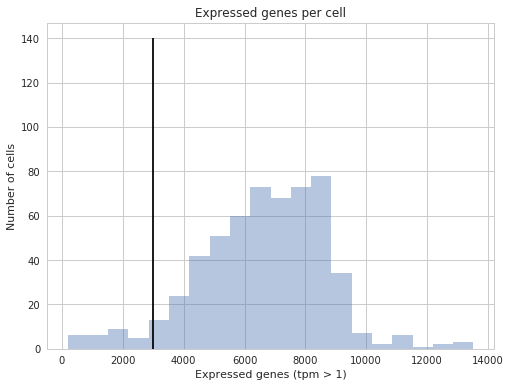

In [12]:
plt.figure(figsize=(8,6))
sns.distplot((kallisto_tpm > 0).sum(axis=0), kde=False)
plt.xlabel("Expressed genes (tpm > 1)")
plt.ylabel("Number of cells")
plt.title("Expressed genes per cell")
plt.vlines(3000, 0,140)

kallisto_tpm.drop( kallisto_tpm.columns[(kallisto_tpm > 0).sum(axis = 0) < 3000] , axis=1, inplace=True)
kallisto_tpm.shape

## PCA plot

In [13]:
pca = sklearn.decomposition.PCA(2)
sc_cols = list(set.intersection(set(sample_table.query("isBulk == False")['Name']), kallisto_tpm.columns))
bulk_cols = list(set.intersection(set(sample_table.query("isBulk == True")['Name']), kallisto_tpm.columns))
sc_transformed = pca.fit_transform(kallisto_tpm[sc_cols].T)
bulk_transformed = pca.transform(kallisto_tpm[bulk_cols].T)

In [14]:
col_key = 'patient_id_s'
sources = sample_table[col_key].unique() 
pal = {s: sns.color_palette('Set2', n_colors=len(sources))[i] for i,s in enumerate(sources)}

pal['BC07LN'] = pal['BC07LN']; del pal['BC07LN']
pal['BC03LN'] = pal['BC03']; del pal['BC03LN']
pal['BC09_Re'] = pal['BC09']; del pal['BC09_Re']

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


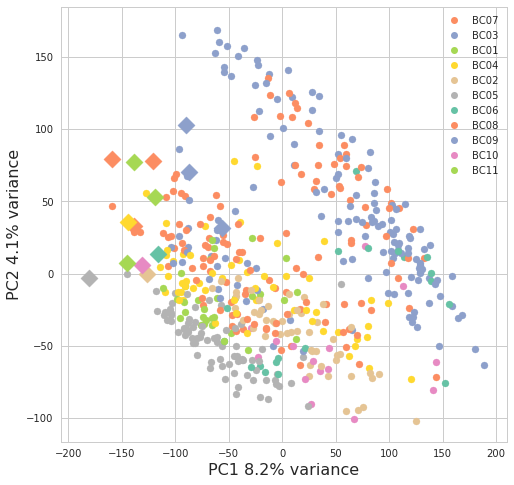

In [15]:
plt.figure(figsize=(8,8))

for i,(_,row) in enumerate(sample_table.set_index('Name').loc[sc_cols].iterrows()):
    plt.scatter(sc_transformed[i,0], sc_transformed[i,1], 
                c=pal[row[col_key][:4]], label=row[col_key])
    
for i,(_,row) in enumerate(sample_table.set_index('Name').loc[bulk_cols].iterrows()):
    plt.scatter(bulk_transformed[i,0], bulk_transformed[i,1], 
                c=pal[row[col_key][:4]], label=row[col_key], marker='D', s=150)


plt.xlabel("PC1 {0:.1f}% variance".format(pca.explained_variance_ratio_[0]*100), size=16)
plt.ylabel("PC2 {0:.1f}% variance".format(pca.explained_variance_ratio_[1]*100), size=16)

plt.legend([plt.Line2D((0,1),(0,0), color=v, marker='o', linestyle='') for v in pal.values()], 
            list(pal.keys()))

# Orginal paper data

Recreate the filtering described by the original authors

In [16]:
# Cells dropped by the original authors because they failed one if their QC metrics

drop_cells = ['BC01_11','BC01_24','BC01_49','BC01_54',
    'BC02_27','BC02_33','BC02_80','BC03_45','BC03_51',
    'BC03_63','BC03_88','BC03LN_77','BC03LN_87','BC04_05',
    'BC04_06','BC04_15','BC04_25','BC05_40','BC06_07',
    'BC06_09','BC06_22','BC06_45','BC06_49','BC06_57',
    'BC06_62','BC07_96', 'BC07LN_20','BC08_12','BC09_02',
    'BC09_27','BC09_54','BC09_Re_68','BC09_Re_72','BC10_27',
]

df = pd.read_table('/srv/shared/vanloo/rna2cn/SRP066982/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt')
print(df.shape)

# Drop cells that failed read level QC
df.drop(drop_cells, axis=1, inplace=True)
df.drop('BC01_Tumor', axis=1, inplace=True)
df.drop(['gene_name', 'gene_type'], axis=1, inplace=True)

sc_cols = [x for x in df.columns if ('Pool' not in x) and ('Tumor' not in x) and ('gene' not in x)]
bulk_cols = [x for x in df.columns if ('Pool' in x) or ('Tumor'  in x)]

# Set genes with TPM < 1 to 0
df.loc[:, sc_cols] = df[sc_cols].where(np.array(df[sc_cols] > 1), other=0)
print(df.shape)


# Drop genes expressed in < 10% of samples
df.drop( df[(df[sc_cols] > 0).mean(axis = 1) < 0.1].index , axis=0, inplace=True)
print(df.shape)

sc_patient = np.array([x[:4] for x in sc_cols])
bulk_patient = np.array([x[:4] for x in bulk_cols])

# log transform
df.loc[:,sc_cols] = np.log2(df[sc_cols] + 1) 
df.loc[:,bulk_cols] = np.log2(df[bulk_cols] + 1) 

sc_tpm = df[sc_cols]
bulk_tpm = df[bulk_cols]
rsem_tpm = df.set_index('gene_id')

(21164, 566)
(21164, 529)
(9876, 529)


In [17]:
rsem_tpm.tail()

,BC01_Pooled,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Pooled,BC05_Pooled,BC06_Pooled,BC07_Tumor,BC07LN_Pooled,BC08_Pooled,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000206585.1,0.000000,0.0,4.634593,3.768714,0.000000,4.31687,0.0,0.0,3.152183,0.000000,...,2.629939,0.0,0.000000,3.124328,0.000000,6.707635,4.399171,5.854245,0.0,0.0
ENSG00000206588.1,4.669027,0.0,4.634593,3.768714,3.116032,4.31687,0.0,0.0,3.152183,5.029453,...,2.629939,0.0,4.909293,3.124328,4.486071,6.707635,4.399171,5.854245,0.0,0.0
ENSG00000206596.1,4.669027,0.0,4.634593,3.768714,3.116032,4.31687,0.0,0.0,3.152183,5.029453,...,2.629939,0.0,4.909293,3.124328,4.486071,6.707635,4.399171,5.854245,0.0,0.0
ENSG00000206652.1,4.669027,0.0,4.634593,3.768714,3.116032,4.31687,0.0,0.0,3.152183,5.029453,...,2.629939,0.0,4.909293,3.124328,4.486071,6.707635,4.399171,5.854245,0.0,0.0
ENSG00000206737.1,4.669027,0.0,4.634593,3.768714,3.116032,4.31687,0.0,0.0,3.152183,5.029453,...,2.629939,0.0,4.909293,3.124328,4.486071,6.707635,4.399171,5.854245,0.0,0.0


NB the last few rows are identical, this is also true in the original published data

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


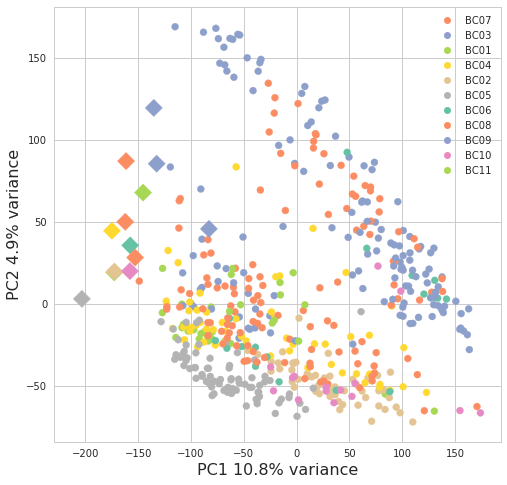

In [18]:
pca = sklearn.decomposition.PCA(2)
sc_transformed =  pca.fit_transform(sc_tpm.T)
bulk_transformed = pca.transform(bulk_tpm.T)
plt.figure(figsize=(8,8))

plt.scatter(sc_transformed[:,0], sc_transformed[:,1], 
            c=[pal[x] for x in sc_patient])
plt.scatter(bulk_transformed[:,0], bulk_transformed[:,1],
            c=[pal[x] for x in bulk_patient],
            marker='D', s=150)

plt.xlabel("PC1 {0:.1f}% variance".format(pca.explained_variance_ratio_[0]*100), size=16)
plt.ylabel("PC2 {0:.1f}% variance".format(pca.explained_variance_ratio_[1]*100), size=16)

plt.legend([plt.Line2D((0,1),(0,0), color=v, marker='o', linestyle='') for v in pal.values()], 
            list(pal.keys()))
paper_pca_ax = plt.gca()

## The Kallisto and the RSEM PCA plots look pretty similar!

# Complare Kallisto and RSEM gene TPMs

In [19]:
kallisto_melt = kallisto_tpm.reset_index().melt(id_vars='gene_id', var_name='sample', value_name='kallisto_tpm')
rsem_melt = rsem_tpm.reset_index().melt(id_vars='gene_id',var_name='sample', value_name='rsem_tpm')
rsem_melt['gene_id'] = rsem_melt['gene_id'].apply(lambda x: x.split('.')[0])
merged = pd.merge(kallisto_melt, rsem_melt, on=['gene_id', 'sample'])

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


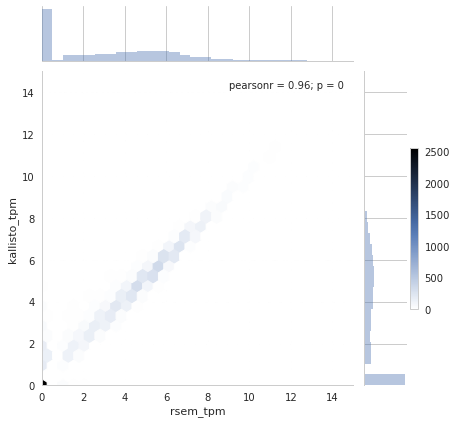

In [20]:
sns.jointplot(data=merged.query("sample == 'BC01_03'"),  x='rsem_tpm', y='kallisto_tpm', kind="hex", xlim=(0,15), ylim=(0,15))
plt.colorbar()

/home/dbunting/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


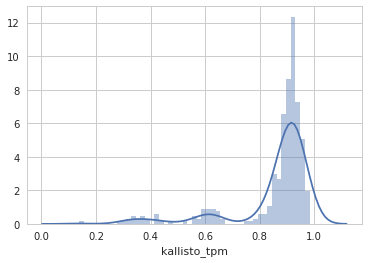

In [21]:
corr = merged.groupby('sample').corr().xs('rsem_tpm', level=1)['kallisto_tpm']
sns.distplot(corr)

All of the lowest peak of correlations ~0.4 are from patient BC04

In [22]:
kallisto_tpm.shape, rsem_tpm.shape

((14267, 533), (9876, 528))